In [1]:
# THERE ARE SEPARATE NOTEBOOKS FOR VISUALIZATIONS, DATASET ANALYSIS, ETC. IN THE REPO.

import pandas as pd
import numpy as np

# READ THE CSV INTO DATAFRAME

df = pd.read_csv('Syngenta/Syngenta_2017/Experiment_dataset.csv')

In [ ]:
# THIS IS USED WHEN CONNECTING TO COMPUTE NODES TO CHECK IF EVERYTHING IS WORKING

import os

print(os.getcwd())

In [ ]:
# CURRENTLY NECESSARY IF: USING 174 ADDITIONAL VARIETY COLUMNS METHOD

variety_dummies = pd.get_dummies(df.Variety)
df = pd.concat([df, variety_dummies], axis=1)

In [ ]:
# CURRENTLY NECESSARY IF: USING 8 ADDITIONAL VARIETY COLUMNS (BINARY REPRESENTATION)

UNIQUE_VARIETIES = np.unique(df.Variety)
INDICES = [i for i in range(0, len(UNIQUE_VARIETIES))]
# print(np.where(UNIQUE_VARIETIES=='V000017'))
df.Variety = df.Variety.apply(lambda var: np.where(UNIQUE_VARIETIES==var)[0][0])
# print(UNIQUE_VARIETIES)
# print(df.Variety)

df.Variety = df.Variety.apply(lambda var: '{0:08b}'.format(var))
print("done")
df.Variety = df.Variety.apply(lambda var: list(var))
print("done")
variety_binary_df = pd.DataFrame(pd.Series(df.Variety[i]) for i in range(0, len(df.Variety)))
df = pd.concat([df, variety_binary_df], axis=1)

In [4]:
# GOAL OF THIS MODULE:
# Encode the planting date as a season

# remove the dates that are "."
df = df[~df['Planting date'].str.match("\.")]
plant_date = df['Planting date'].apply(lambda dt: pd.to_datetime(dt))
plant_months = plant_date.apply(lambda dt: dt.month)
season = plant_date.rename("Season")
season = pd.to_datetime(season)
season = season.apply(lambda dt: (dt.month%12 + 3)//3)
# df['Plant date'] = pd.to_datetime(df['Plant date'])
df = pd.concat([df, season], axis=1)

# plant_date = pd.to_datetime(df['Planting date'], infer_datetime_format=True)
# df = df['Planting date'].apply(lambda dt: (dt.month%12 + 3)//3)
# pd.get_dummies(df['Planting date'])

In [5]:
# ADD MONTH OF MAY AND JUNE ONE HOT ENCODING INTO THE DATAFRAME
pd.get_dummies(plant_months).sum()
june = pd.get_dummies(plant_months).loc[:,6]
june = june.rename("June")
may = pd.get_dummies(plant_months).loc[:,5]
may = may.rename("May")
df = pd.concat([df, may], axis=1)
df = pd.concat([df, june], axis=1)

In [ ]:
# LATITUDE AND LONGITUDE CLUSTERING INTO FEATURES

from sklearn.cluster import KMeans

latlong = df.loc[:, ['Latitude', 'Longitude']]

kmeans = KMeans(n_clusters=4, random_state=0).fit(latlong)
kmeans.labels_.shape
lat_long_dummies = pd.get_dummies(kmeans.labels_)
lat_long_dummies = lat_long_dummies.rename(index=int, columns={0: "Loc Clust 0",
                                                               1: "Loc Clust 1",
                                                               2: "Loc Clust 2",
                                                               3: "Loc Clust 3"})
df = pd.concat([df, lat_long_dummies], axis = 1)

In [ ]:
#REMOVE ANY NAN VALUES

print(df.columns)
df = df[~df.Silt.isnull()]
df = df[~df['Loc Clust 1'].isnull()]

In [7]:
for col in df.columns:
    print(col, type(df[col][0]))

Experiment <class 'str'>
Location <class 'numpy.int64'>
Variety <class 'list'>
Planting date <class 'str'>
Yield <class 'numpy.float64'>
Check Yield <class 'numpy.float64'>
Yield difference <class 'numpy.float64'>
Year <class 'numpy.int64'>
Latitude <class 'numpy.float64'>
Longitude <class 'numpy.float64'>
Temperature <class 'numpy.float64'>
Precipitation <class 'numpy.float64'>
Solar Radiation <class 'numpy.int64'>
Soil class <class 'numpy.int64'>
CEC <class 'numpy.float64'>
Organic matter <class 'numpy.float64'>
pH <class 'numpy.float64'>
Clay <class 'numpy.float64'>
Silt <class 'numpy.float64'>
Sand <class 'numpy.float64'>
PI <class 'str'>
Area <class 'numpy.float64'>
0 <class 'str'>
1 <class 'str'>
2 <class 'str'>
3 <class 'str'>
4 <class 'str'>
5 <class 'str'>
6 <class 'str'>
7 <class 'str'>
Season <class 'numpy.int64'>
May <class 'numpy.uint8'>
June <class 'numpy.uint8'>


In [10]:
# DROP ALL THE CELLS THAT ARE NOT USABLE SUCH AS THE ONES THAT ARE STRINGS OR DATES

# set if want to drop some columns specifically
should_drop = 1
columns_to_drop = ['Experiment', 'Location',
                   'Check Yield', 'Yield difference', 'Latitude',
                   'Longitude', 'PI', 'Variety', 'Planting date', 'Season']

# set if want to keep some columns specifically
should_keep = 0
# columns_to_keep = ['Loc Clust 0', 'Loc Clust 1', 'Loc Clust 2', 'Loc Clust 3']
columns_to_keep_top = ['Silt', 'Precipitation', 'Temperature', 'Solar Radiation', 'Organic matter']
# columns_VARIETIES_ONLY = np.asarray(df.iloc[:, df.columns.str.match('V\d\d\d\d\d\d')].columns)

#set the below variable to whatever columns you want to keep
columns_to_keep = columns_to_keep_top

MUST_HAVE_COLUMNS = ['Yield']
# print(columns_to_keep)

df = df.drop(columns_to_drop, axis=1) if should_drop else df
df = df.loc[:, np.concatenate((columns_to_keep, MUST_HAVE_COLUMNS))] if should_keep else df
df['YieldBucket'] = pd.Series(pd.qcut(df.Yield, q=3, labels=["high", "medium", "low"]))
print("The final dataframe has columns: ", df.columns)

The final dataframe has columns:  Index([          'Yield',            'Year',     'Temperature',
         'Precipitation', 'Solar Radiation',      'Soil class',
                   'CEC',  'Organic matter',              'pH',
                  'Clay',            'Silt',            'Sand',
                  'Area',                 0,                 1,
                       2,                 3,                 4,
                       5,                 6,                 7,
                   'May',            'June',     'YieldBucket'],
      dtype='object')


In [11]:
# LET US ALSO MAKE SURE THERE ARE NO NAN IN THE DATA

print("We expect to be %s nan values and there actually are %s nan values\n" % (0, np.sum(df.isnull().sum())))
print(df.isnull().sum())
# AFTER COLUMNS, MAKE SURE NO SKETCHY ONES
for col in df.columns:
    print(col, type(df[col][0]))    

We expect to be 0 nan values and there actually are 0 nan values

Yield              0
Year               0
Temperature        0
Precipitation      0
Solar Radiation    0
Soil class         0
CEC                0
Organic matter     0
pH                 0
Clay               0
Silt               0
Sand               0
Area               0
0                  0
1                  0
2                  0
3                  0
4                  0
5                  0
6                  0
7                  0
May                0
June               0
YieldBucket        0
dtype: int64
Yield <class 'numpy.float64'>
Year <class 'numpy.int64'>
Temperature <class 'numpy.float64'>
Precipitation <class 'numpy.float64'>
Solar Radiation <class 'numpy.int64'>
Soil class <class 'numpy.int64'>
CEC <class 'numpy.float64'>
Organic matter <class 'numpy.float64'>
pH <class 'numpy.float64'>
Clay <class 'numpy.float64'>
Silt <class 'numpy.float64'>
Sand <class 'numpy.float64'>
Area <class 'numpy.float64'>
0 <cl

In [12]:
# TRAIN AND TEST SPLIT# TRAIN AND TEST SPLIT# TRAIN AND TEST SPLIT
# TRAIN AND TEST SPLIT# TRAIN AND TEST SPLIT# TRAIN AND TEST SPLIT

X = df.drop(['Yield', 'YieldBucket'], axis=1)

print(X.columns)

y = df.Yield

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05, train_size = 0.1, random_state = 42)

INPUT_COLS = X_train.columns
# TEST_COLS = y_train.columns

Index([           'Year',     'Temperature',   'Precipitation',
       'Solar Radiation',      'Soil class',             'CEC',
        'Organic matter',              'pH',            'Clay',
                  'Silt',            'Sand',            'Area',
                       0,                 1,                 2,
                       3,                 4,                 5,
                       6,                 7,             'May',
                  'June'],
      dtype='object')


In [13]:
print("X_train shape:", X_train.shape, "\ny_train shape:", y_train.shape)

X_train shape: (8008, 22) 
y_train shape: (8008,)


In [32]:
# GOAL OF THIS MODULE: PCA OUTPUT AND ANALYSIS

from sklearn.preprocessing import StandardScaler

vis_features = []

X_train_scaled = StandardScaler().fit_transform(X_train)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_train_scaled)
principal_df = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
final_df = pd.concat([principal_df, df['YieldBucket']], axis=1)

In [28]:
np.unique(df.YieldBucket)

array(['high', 'low', 'medium'], dtype=object)

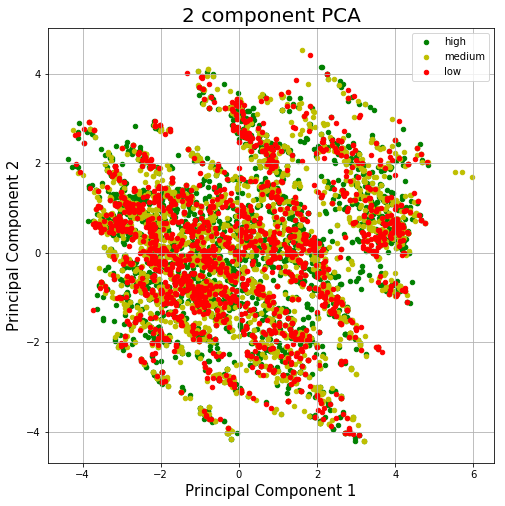

In [34]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['high', 'medium', 'low']
colors = ['g', 'y', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = final_df['YieldBucket'] == target
    ax.scatter(final_df.loc[indicesToKeep, 'principal component 1']
               , final_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 20)
# ax.scatter(final_df.loc[:, 'principal component 1'],
#           final_df.loc[:, 'principal component 2'],
#           s = 10)
ax.legend(targets)
ax.grid()

In [ ]:
# THIS FUNCTION WILL EVALUATE ERRORS BASED ON RMSE (FROM SYNGENTA CHALLENGE SPEC)
# AND ALSO WILL EVALUATE BASED ON AVERAGE ERROR

from sklearn.metrics import mean_squared_error

def evaluate_errors(prediction, actual):
    print("RMSE Error: ", np.sqrt(mean_squared_error(prediction, actual)))
    avg_error_vector = np.absolute(((preds - y_test) / y_test) * 100)
    print("Average Error details:\n", avg_error_vector.describe())
    return avg_error_vector

In [ ]:
# MOST USED CLASSIFIER CURRENTLY

from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(n_estimators=20, max_depth=13, random_state=0, verbose=1, n_jobs=-1)
regr.fit(X_train, y_train)
preds = regr.predict(X_test)
evaluate_errors(preds, y_test)

In [ ]:
# GET OUTPUT OF FEATURE IMPORTANCE

def get_feature_importances(regr):
    feature_importances = regr.feature_importances_
    feature_importances = pd.Series(feature_importances)
    feature_importance_df = pd.DataFrame({'feature': X_train.columns,'feature_importance': feature_importances})
    feature_importance_df = feature_importance_df.sort_values(by=['feature_importance'])
    for index, row in feature_importance_df.iterrows():
        print(row['feature'], 'has importance: ', row['feature_importance'])
get_feature_importances(regr)

In [ ]:
# CREATE AN ARRAY OF POTENTIAL CLASSIFIERS TO TEST THE PERFORMANCE OF EACH AND COMPARE

from sklearn import linear_model
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble

GRAD_BOOST_PARAMS = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}

classifiers = [
#     MLPRegressor(solver='lbfgs', alpha=1e-5,
#                      hidden_layer_sizes=(5, 2), random_state=1),
#     RandomForestRegressor(n_estimators=20, max_depth=13, random_state=0, verbose=1, n_jobs=-1),
#     linear_model.SGDRegressor(),
#     linear_model.BayesianRidge(),
#     linear_model.LassoLars(),
#     linear_model.ARDRegression(),
#     linear_model.PassiveAggressiveRegressor(),
#     linear_model.TheilSenRegressor(),
#     linear_model.LinearRegression(),
    LGBMRegressor(n_estimators=1000, learning_rate=0.01),
    svm.SVR(kernel="linear"),
    linear_model.ARDRegression(),
    ensemble.GradientBoostingRegressor(**GRAD_BOOST_PARAMS)]

In [ ]:
# THIS MODULE WILL OUTPUT A DICTIONARY WITH THE FEATURE RANKING OF A CLASSIFIER

from sklearn.feature_selection import RFECV
def RFEVC_(clf, X_train_, y_train_, step_=1, verbose_=0):
    selector = RFECV(clf, step=step_, verbose=verbose_, n_jobs=-1)
    selector = selector.fit(X_train_, y_train_)
    
    INPUT_COLS = X_train.columns
    RANKS = selector.ranking_

    rank_dict = {}
    for idx, item in enumerate(RANKS):
        rank_dict[INPUT_COLS[idx]] = item
    
    import pprint
    pprint.pprint(rank_dict)
    
    return rank_dict, selector

# USAGE EXAMPLE:
# rank_dict, selec = RFEVC_(regr, X_train, y_train)

In [ ]:
# RUN THE RECURSIVE FEATURE ELIMINATION ON EACH CLASSIFIER IN THE ARRAY

for item in classifiers:
    print(item)
    clf = item
    rank_dict, selector = RFEVC_(clf, X_train, y_train)

In [ ]:
# RUN THE CLASSIFIERS AND PREDICT ON TEST DATA

for item in classifiers:
    print(item)
    clf = item
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    errors = evaluate_errors(preds, y_test)
    try:
        get_feature_importances(clf)
    except:
        print("NO FEATURE IMPORTANCE METRIC")

In [ ]:
import random

NUM_VARIETIES = 174

def best_yield_variety(regr, test_set, random_sel = True, n_samples = 174, print_variety_preds = True):
    
    #create empty df
    dup_df = pd.DataFrame()
    
    #choose a rand sample of input test_set (for dev purposes, wouldn't be used in app)
    test_set_sample = test_set.sample(n= n_samples) if random_sel else test_set
    
    #progress of intensive, long for loop upcoming
    counter = 0
    
    #for loop will, for each row in test_set_sample, duplicate that row by NUM_VARIETIES
    for index, row in test_set_sample.iterrows():
        counter+=1
        print(counter)
        dup_df = dup_df.append([row] * NUM_VARIETIES, ignore_index = True)
        
    #extract the varieties columns
    duplicated_df_varieties = dup_df.loc[:, dup_df.columns.str.match('V\d\d\d\d\d\d')]
    #extract the names of the varieties
    varieties_array = duplicated_df_varieties.columns
    num_expanded_data_pts = duplicated_df_varieties.shape[0]
    #we must have a zeroed matrix of the same shape as the duplicated_df_varieties
    #so that we can input a 1 just once for each variety per 174 rows
    d = np.zeros((duplicated_df_varieties.shape[0], NUM_VARIETIES))
    #make d our dataframe, with columns equal to the varieties
    duplicated_df_varieties = pd.DataFrame(d, columns=varieties_array)
    #for loop will place a 1 just once for each variety per 174 rows (one hot rep)
    for i in range(duplicated_df_varieties.shape[0]):
        var_index = i % 174
        duplicated_df_varieties.loc[i, varieties_array[var_index]] = 1
    #remove the varieties (will be added back with the new values)
    dup_df = dup_df.drop(varieties_array, axis = 1)
    #add the new values (one hot representations) from above for loop
    dup_df = pd.concat([dup_df, duplicated_df_varieties], axis=1)
    #do prediction on the entire dataframe
    preds_per_variety = regr.predict(dup_df)
    #*******make it into a dataframe where each row will give the performance of each variety
    #with the same environmental conditions*******
    preds_df = pd.DataFrame(preds_per_variety.reshape((int(num_expanded_data_pts/NUM_VARIETIES), NUM_VARIETIES)),
                            columns=varieties_array)
    
    #environmental conditions (everything except the variety data)
    envcond = test_set_sample.drop(varieties_array, axis=1)
    
    #a simple print out for best variety given the environmental conditions
    hr_preds = []
    if print_variety_preds:
        envcond_cols = envcond.columns
        counter = -1
        for idx, row in envcond.iterrows():
            counter+=1
            out = "For environmental conditions:\n%s\nthe best variety is:%s" % (row, preds_df.idxmax(axis=1)[counter])
            hr_preds.append(out)
            print(out)
    
    return preds_df, envcond, hr_preds
    
        
preds_df, envcond, hr_preds = best_yield_variety(regr, X_test, n_samples = 500)

In [ ]:
#find number of times a variety is the maximum in the above prediction dataframe
maxes = preds_df.idxmax(axis=1) # get first max variety per env
# print(pd.get_dummies(maxes).describe())
print(pd.get_dummies(maxes).sum().sort_values(ascending=False))

In [ ]:
#find number of times a variety is the maximum in the above prediction dataframe
maxes = preds_df.idxmax(axis=1) # get first max variety per env
# print(pd.get_dummies(maxes).describe())
print(pd.get_dummies(maxes).sum().sort_values(ascending=False))
print(len(pd.get_dummies(maxes).sum()))

In [ ]:
preds_df.describe().sort_values(by="mean", axis=1)

In [ ]:
preds_df.describe().loc['mean',:].sort_values().describe()

In [ ]:
# CLASSIFICATION METHODS BELOW!

In [ ]:
# THIS WILL ONLY WORK WITH THE BUCKET METHOD

from sklearn.ensemble import RandomForestClassifier
regr = RandomForestClassifier(n_estimators=10, max_depth=20, random_state=0, verbose=1)
regr.fit(X_train, y_train)
preds = regr.predict(X_test)

from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, preds))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classifiers = [
#     KNeighborsClassifier(3),
#     SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
#     GaussianProcessClassifier(1.0 * RBF(1.0)),
#     DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]
from sklearn.metrics import accuracy_score
for item in classifiers:
    print(item)
    clf = item
    clf.fit(scale(X_train), y_train)
    preds = clf.predict(scale(X_test))
    print(accuracy_score(y_test, preds))
#     errors = np.absolute(((preds - y_test) / y_test) * 100)
#     print(errors)
#     print(np.mean(errors))